# “Hello, world!”

Import Sionna:

这部分是用来配置基本的环境

In [4]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

Let us first create a [BinarySource](https://nvlabs.github.io/sionna/api/utils.html?highlight=binarysource#binarysource) to generate a random batch of bit vectors that we can map to constellation symbols:

- `batch_size`是**随机二进制序列**的大小；被设置为1000，表示要生成**1000**个符号
- `num_bits_per_symbol`是每个随机数的位数，为**4位**
- `sionna.utils.BinarySource`这是一个类，作用是用于生成随机的二进制序列，创建了一个对象`binary_source `
- 通过调用`binary_source([batch_size, num_bits_per_symbol])`方法，生成了一个形状为`(batch_size, num_bits_per_symbol)`的二进制矩阵，其中每行表示一个符号，每列表示一个比特
- 生成的随机二进制序列存储在变量`b`中

In [5]:
batch_size = 1000 # Number of symbols we want to generate
num_bits_per_symbol = 4 # 16-QAM has four bits per symbol
binary_source = sionna.utils.BinarySource()
b = binary_source([batch_size, num_bits_per_symbol])
b

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.],
       ...,
       [1., 1., 1., 0.],
       [1., 0., 1., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

Next, let us create a [Constellation](https://nvlabs.github.io/sionna/api/mapping.html#sionna.mapping.Constellation) and visualize it:

- `sionna.mapping.Constellation("qam", num_bits_per_symbol)` 是用来创建一个**调制符号映射**（constellation mapping）
- 两个重要参数：
    - constellation_type: ["qam", "pam", "custom"]
        - `**qam**`   QAM（Quadrature Amplitude Modulation，正交幅度调制）是一种数字通信调制技术，常用于无线通信和有线数字通信中。它的基本原理是通过同时变化信号的相位和幅度来编码信息，从而在有限的频谱带宽内传输更多的数据.在QAM中，信号被分为两个正交的部分：一个是正弦信号（通常用于表示实部），另一个是余弦信号（通常用于表示虚部）。通过调节这两个信号的幅度和相位，可以编码不同的数据比特。例如，对于16-QAM（16-Quadrature Amplitude Modulation），每个符号可以表示4个比特，因为16 = 2^4。
        - `**pam**`  PAM（Pulse Amplitude Modulation，脉冲幅度调制）是一种基本的数字调制技术，用于将数字信号转换为模拟信号。在PAM中，数字信号通过改变脉冲的幅度来表示，每个脉冲代表一个离散的数字值。PAM通常用于基带信号的调制，是许多其他调制方式的基础。PAM的工作原理很简单：将模拟信号分为不同的离散级别，每个级别对应一个数字值。然后，将数字信号转换为一系列脉冲，每个脉冲的幅度表示对应的数字值。PAM常见的调制方式包括二进制PAM（2-PAM）、四进制PAM（4-PAM）、八进制PAM（8-PAM）等，其中数字值的数量取决于PAM的调制级别。
        - `**custom**`  对于“custom”，如果未提供，星座点将随机初始化
    - `num_bits_per_symbol` 是每个随机数的位数，为**4位**
- constellation 是生成的对象

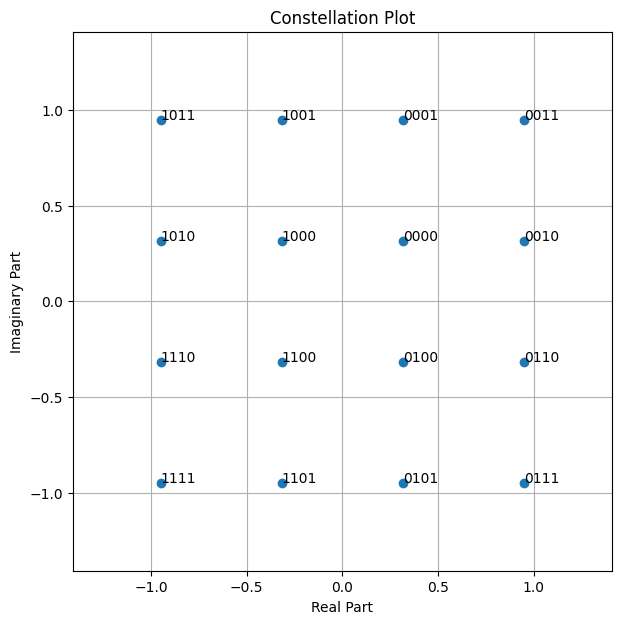

In [6]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
constellation.show();

We now need a [Mapper](https://nvlabs.github.io/sionna/api/mapping.html#mapper) that maps each row of b to the constellation symbols according to the bit labeling shown above.

这段代码中，首先创建了一个名为 `mapper` 的映射器对象，并传入了一个名为 `constellation` 的星座对象作为参数。然后，通过调用`mapper(b)` 方法，对输入的数据 `b`进行信号映射操作，将**数字信号**转换为**星座符号**，并将结果存储在变量 `x `中。最后，通过`x[:10]` 获取了 `x` 中的前10个元素。

这个过程涉及到`信号映射器类`中的 `call` 方法的调用，该方法对输入的数据进行了形状变换、类型转换，并根据输入的整数表示在星座对象中查找对应的星座符号。因此，`x[:10]` 是获取了映射后的结果中的前10个星座符号。

In [10]:
mapper = sionna.mapping.Mapper(constellation=constellation)
x = mapper(b)
x[:10]

<tf.Tensor: shape=(10, 1), dtype=complex64, numpy=
array([[-0.9486833+0.3162278j],
       [-0.3162278+0.9486833j],
       [ 0.3162278-0.9486833j],
       [ 0.3162278-0.9486833j],
       [ 0.9486833-0.3162278j],
       [ 0.9486833-0.3162278j],
       [-0.9486833+0.3162278j],
       [ 0.3162278-0.3162278j],
       [ 0.3162278-0.9486833j],
       [ 0.3162278-0.9486833j]], dtype=complex64)>

Let us now make things a bit more interesting a send our symbols over and [AWGN channel](https://nvlabs.github.io/sionna/api/channel.html#sionna.channel.AWGN):

- 这里涉及到**sionna**的**channel**子模块里的**AWGN**方法：

    - AWGN代表加性白噪声（Additive White Gaussian Noise），是数字通信中常见的一种噪声模型。它的特点包括：

        1. **加性（Additive）**：表示噪声是在信号上叠加的，即信号与噪声是相加的关系。在数字通信中，信号经过信道传输时会受到噪声的影响，噪声会与信号相加，导致信号的失真和误差。

        2. **白噪声（White Noise）**：表示噪声在所有频率上具有均匀分布的功率谱密度，即在整个频谱范围内具有相同的功率。这种特性使得白噪声在频域上呈现均匀的能量分布，没有特定的频率成分。

        3. **高斯噪声（Gaussian Noise）**：表示噪声的幅度遵循高斯分布（也称为正态分布），即噪声的幅度随机但服从高斯分布的统计规律。在实际应用中，许多环境中的噪声都可以近似地视为高斯分布的噪声。
                        
        AWGN模型通常用于对数字通信系统的性能进行建模和仿真。在仿真过程中，可以将`AWGN`加到信号中，模拟信号在传输过程中受到的噪声干扰，以评估系统的**误码率**、**信噪比**等性能指标。
        
    - 创建了一个名为 `awgn` 的AWGN（Additive White Gaussian Noise，加性白噪声）信道对象
    - `no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)`这段代码使用了 `sionna.utils.ebnodb2no` 函数来计算信噪比（SNR）的噪声功率谱密度。

        1. `ebno_db`：表示所需的信噪比（Eb/No），以分贝（dB）为单位给出。Eb/No是指信号能量与噪声功率谱密度之比，通常用于衡量数字通信系统中信号的质量和可靠性。

        2. `num_bits_per_symbol`：表示每个符号所传输的比特数。在数字通信中，一个符号可以携带多个比特的信息，而 `num_bits_per_symbol` 就是指定了每个符号的比特数。

        3. `coderate=1`：表示编码率，默认为1，即无编码。编码率是指每个信息比特对应的编码比特的数量。

        根据这些输入参数，`sionna.utils.ebnodb2no` 函数会计算出对应于指定的Eb/No和编码率的噪声功率谱密度，返回的结果存储在变量 `no` 中。这个噪声功率谱密度在数字通信系统中用于模拟加性白噪声（AWGN）信道中的噪声水平，进而影响信号的接收质量和性能。
        
    - 然后使用了该AWGN信道对象对信号 `x` 进行了加噪处理，生成了带有噪声的接收信号 `y`。

- 通过引入Matplotlib库对接收信号 `y` 进行了可视化展示。具体步骤包括：

    1. 导入Matplotlib库：`import matplotlib.pyplot as plt`

    2. 导入NumPy库：`import numpy as np`

    3. 创建一个Matplotlib图形对象：`fig = plt.figure(figsize=(7,7))`

    4. 在图形上添加一个子图：`ax = fig.add_subplot(111)`

    5. 绘制接收信号的散点图：`plt.scatter(np.real(y), np.imag(y));`

    6. 设置坐标轴纵横比为1:1，使得散点图呈现正圆形：`ax.set_aspect("equal", adjustable="box")`

    7. 设置x和y轴的标签：`plt.xlabel("Real Part")` 和 `plt.ylabel("Imaginary Part")`

    8. 显示网格线：`plt.grid(True, which="both", axis="both")`
    
    9. 设置图形标题：`plt.title("Received Symbols")`
        

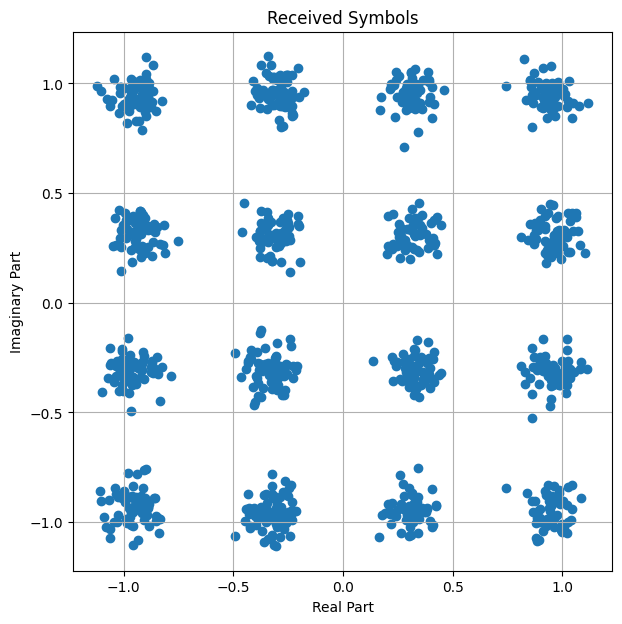

In [8]:
awgn = sionna.channel.AWGN()
ebno_db = 15 # Desired Eb/No in dB
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
y = awgn([x, no])

# Visualize the received signal
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y), np.imag(y));
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True, which="both", axis="both")
plt.title("Received Symbols");